In [119]:
import sys
sys.path.append("./../..")

In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:

#
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
#
from effcn.models_mnist import CapsNet, CapsNetCross,EffCapsNetCross, EffCapsNet
from misc.utils import count_parameters, calc_receptive_field, layer_conv, bb_pc_vals, calc_layer_combs, rf_layer_combs
from misc.plot_utils import imshow, plot_mat

### Local Func

In [122]:
def show_imgrid(x,y=None,nrow=8):
    if y is not None and (y.shape[-1] % nrow) == 0:
        print(y.view(-1,nrow))

    img = torchvision.utils.make_grid(x[:64,:1,:,:], nrow=nrow)
    img = img.permute((1,2,0))
    plt.imshow(img)
    plt.show()


In [123]:
def show_pc_vals(pc, ncol=8, cmap="copper", figsize=(12,50)):
    """
    IN: mat -> torch.tensor(pc_no, pc_dim), Primecaps of one Input 
    """
    
    mat = pc.view(ncol, -1, pc.shape[1])
    mat = mat.cpu().detach().numpy()
    
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(1, mat.shape[0], sharex=False, sharey=True)

    for i in range(mat.shape[0]):
        ax[i].imshow(mat[i], cmap="copper")

    plt.show()

In [124]:
def calc_pc_delta(pc1, pc2):
    """
    generate norm over capsule dimension
    subtract values of 2 inputs elementwise
    generate norm over dims for scarlar output -> maybe some better way?

    IN: pc1, pc2 -> PrimeCaps of 2 inputs (pc_no, pc_dim)
    OUT: norm_delta -> calculated delta
    """
    pc1 = pc1.norm(dim=-1) 
    pc2 = pc2.norm(dim=-1)
    delta = pc1 - pc2
    norm_delta = delta.norm(dim=-1)
    return norm_delta

In [125]:
def calc_pc_norm_kld(pc1, pc2):
    """
    generate norm over capsule dimension
    subtract values of 2 inputs elementwise
    generate norm over dims for scarlar output -> maybe some better way?

    IN: pc1, pc2 -> PrimeCaps of 2 inputs (pc_no, pc_dim)
        ||pc1||^2 -> P  
        ||pc2||^2 -> Q  
    OUT: kld  -> kld over norm
    """
    pc1 = pc1.norm(dim=-1)
    pc2 = pc2.norm(dim=-1)
    kld = F.kl_div(pc2.log(), pc1, None, None, 'sum')
    return kld

In [197]:
def affine_xtrans(img, target, range=[-5.,5.,1]):
    """
    generate one transform output for each value in range
    x transpose
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    x_trans = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        x_trans[i] = T.functional.affine(img=img, angle=0, translate=[l,0], scale=1.,shear=0)
        l_target[i] = target
    
    return x_trans, l_target

def affine_ytrans(img, target, range=[-5.,5.,1]):
    """
    generate one transform output for each value in range
    y transpose
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    y_trans = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        y_trans[i] = T.functional.affine(img=img, angle=0, translate=[0,l], scale=1.,shear=0)
        l_target[i] = target
    
    return y_trans, l_target

def affine_rot(img, target, range=[-25.,25.,1]):
    """
    generate one transform output for each value in range
    rotation
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    rot = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        rot[i] = T.functional.affine(img=img, angle=l, translate=[0,0], scale=1.,shear=0)
        l_target[i] = target
    print(img.shape)
    
    return rot, l_target

def affine_scale(img, target, range=[0.75,1.25,0.05]):
    """
    generate one transform output for each value in range
    scale
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    rot = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        rot[i] = T.functional.affine(img=img, angle=0, translate=[0,0], scale=l,shear=0)
        l_target[i] = target
    
    return rot, l_target


def affine_shear(img, target, range=[-10.,10.,2]):
    """
    generate one transform output for each value in range
    shear
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    rot = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        rot[i] = T.functional.affine(img=img, angle=0, translate=[0,0], scale=1,shear=l)
        l_target[i] = target
    
    return rot, l_target

In [189]:
def plt_lin(vals):
    """
    simple x y plot
    """
    norm_lin = np.arange(0,len(vals),1)

    plt.plot(norm_lin, vals)
    plt.show

### Load Dataset

In [127]:
p_data = '/mnt/data/datasets'

In [128]:
ds = datasets.MNIST(root=p_data, train=False,download=False, transform=T.ToTensor())

In [129]:
bs = 32
shuffle=False
dl = torch.utils.data.DataLoader(ds,batch_size=bs,shuffle=shuffle)

In [130]:
x, y = next(iter(dl))

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


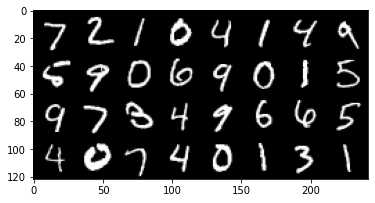

In [131]:
show_imgrid(x,y,nrow=8)

### Load Model

In [132]:
#p_model = '/mnt/data/experiments/CN/mnist/mnist_CapsNet_2022_05_17_13_28_17/ckpts/model_150.ckpt'
p_model = '/mnt/data/experiments/CN_cross/mnist/mnist_CapsNet_2022_05_25_12_22_50/ckpts/model_150.ckpt'

In [133]:
CN = CapsNet()
CN.load_state_dict(torch.load(p_model))
CN.eval()

CapsNet(
  (backbone): BackboneHinton(
    (layers): Sequential(
      (0): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (primcaps): PrimaryCapsLayer(
    (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    (squash): SquashHinton()
  )
  (digitcaps): CapsLayer(
    (routing_module): AgreementRouting(
      (squash): SquashHinton()
    )
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [134]:
y_pred, x_reg = CN(x)

print(y_pred.shape, x_reg.shape)

torch.Size([32, 10, 16]) torch.Size([32, 1, 28, 28])


tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


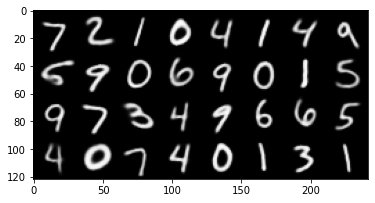

In [135]:
show_imgrid(x_reg,y,nrow=8)

In [136]:
u_h, x_rec, u_l, bb = CN.forward_pc_study(x)

print('Backbone Shape:       {}'.format(bb.shape))
print('PrimeCaps Shape:      {}'.format(u_l.shape))
print('ClassCaps Shape:      {}'.format(u_h.shape))
print('Reconstruction Shape: {}'.format(x_rec.shape))

Backbone Shape:       torch.Size([32, 256, 20, 20])
PrimeCaps Shape:      torch.Size([32, 1152, 8])
ClassCaps Shape:      torch.Size([32, 10, 16])
Reconstruction Shape: torch.Size([32, 1, 28, 28])


In [137]:
mat = u_l[0].cpu().detach().numpy()

u_l[0].shape, u_l[0].max(), u_l[0].min()

(torch.Size([1152, 8]),
 tensor(0.9995, grad_fn=<MaxBackward1>),
 tensor(-0.9987, grad_fn=<MinBackward1>))

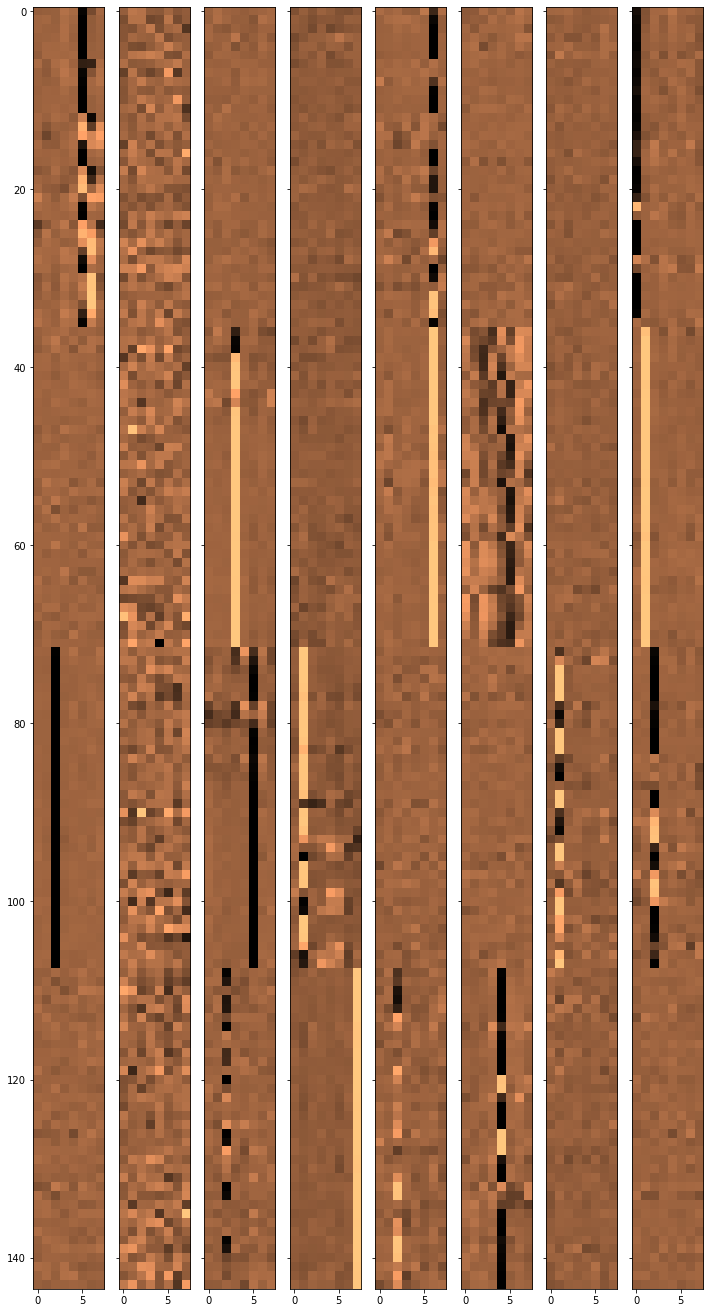

In [138]:
show_pc_vals(pc=u_l[7], ncol=8, cmap="copper", figsize=(12,50))

torch.Size([1152, 8])
tensor(0.9999, grad_fn=<MaxBackward1>) tensor(0.0075, grad_fn=<MinBackward1>) torch.Size([1152, 1])


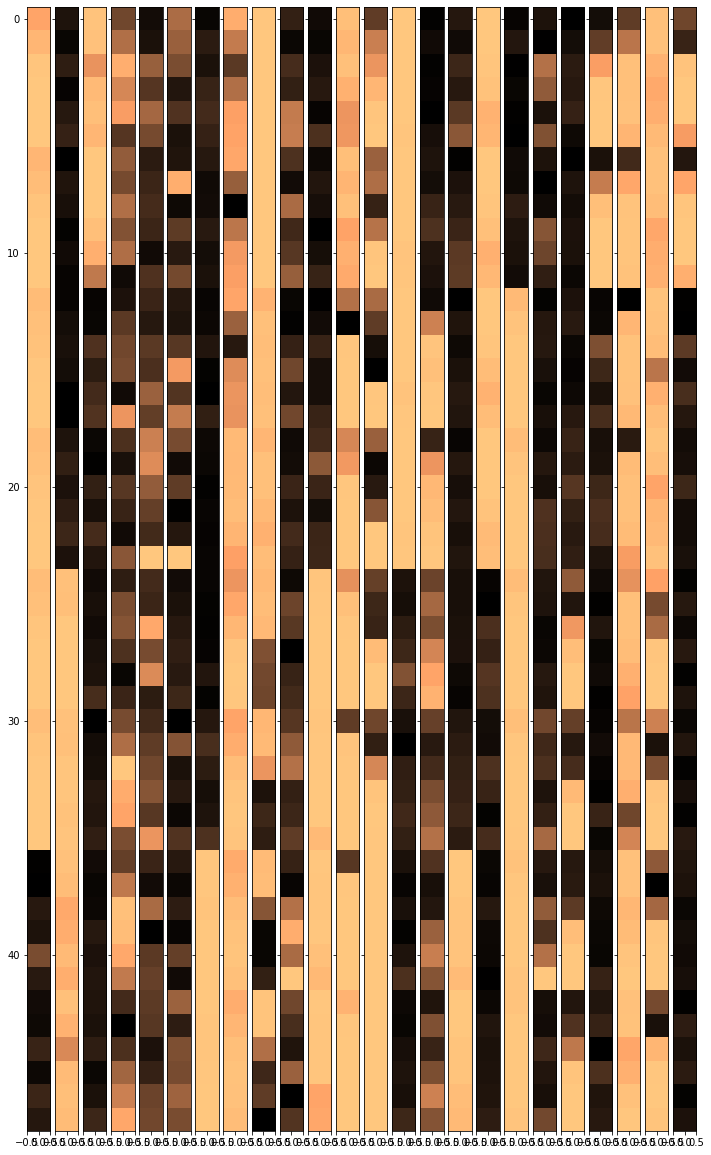

In [139]:
print(u_l[4].shape)

u_norm = u_l[5].norm(dim=1,keepdim=True)

print(u_norm.max(), u_norm.min(), u_norm.shape)

show_pc_vals(pc=u_norm , ncol=24, cmap="copper", figsize=(12,50))

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


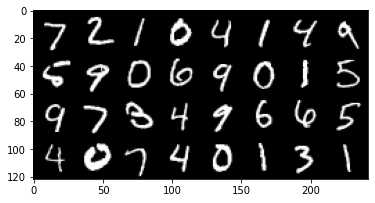

In [140]:
show_imgrid(x,y,nrow=8)

In [141]:
# test same numbers

# generate norm over capsule dimension
# subtract values of 2 inputs elementwise
# generate norm over dims for scarlar output -> maybe some better way?

n1 = u_l[4].norm(dim=1)
n2 = u_l[6].norm(dim=1)

print(n1.norm(), n2.norm())
print((n1-n2).norm())

n3 = u_l[0].norm(dim=1)

print(n1.norm(), n3.norm())
print((n1-n3).norm())

print((n3-n1).norm())
print((u_l[4]-u_l[0]).norm())



tensor(23.1063, grad_fn=<CopyBackwards>) tensor(22.5932, grad_fn=<CopyBackwards>)
tensor(5.0927, grad_fn=<CopyBackwards>)
tensor(23.1063, grad_fn=<CopyBackwards>) tensor(22.2777, grad_fn=<CopyBackwards>)
tensor(5.5425, grad_fn=<CopyBackwards>)
tensor(5.5425, grad_fn=<CopyBackwards>)
tensor(25.0638, grad_fn=<CopyBackwards>)


In [142]:
calc_pc_delta(pc1=u_l[4], pc2=u_l[6])

tensor(5.0927, grad_fn=<CopyBackwards>)

### SHow Transforms 

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


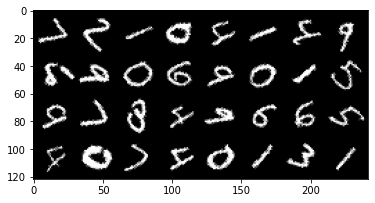

In [143]:
# https://pytorch.org/vision/stable/transforms.html
x_tf = TF.rotate(x, -50)

show_imgrid(x_tf,y,nrow=8)

torch.Size([32, 10, 16]) torch.Size([32, 1, 28, 28])
tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


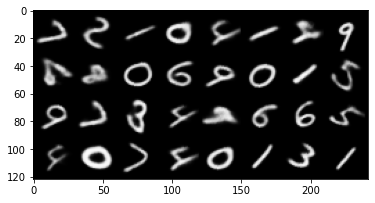

In [144]:
u_h_tf, x_rec_tf, u_l_tf, bb_tf = CN.forward_pc_study(x_tf)

print(y_pred.shape,  x_rec_tf.shape)

show_imgrid( x_rec_tf,y,nrow=8)

In [145]:
idx = 6

calc_pc_delta(pc1=u_l[idx], pc2=u_l_tf[idx])

tensor(5.5001, grad_fn=<CopyBackwards>)

In [146]:
calc_pc_delta(pc1=u_l, pc2=u_l_tf)

tensor([5.1649, 5.4821, 5.6885, 4.4615, 5.6402, 5.6818, 5.5001, 4.9892, 5.3946,
        5.5012, 3.9522, 5.3565, 5.2167, 4.6204, 5.3065, 5.7319, 4.8236, 5.1555,
        5.7299, 5.2248, 5.1631, 4.9997, 6.4030, 5.0206, 6.2533, 5.0155, 5.1811,
        5.4017, 4.8369, 5.9733, 4.7485, 6.1843], grad_fn=<CopyBackwards>)

### random input

torch.Size([1, 1, 28, 28])


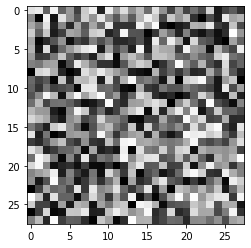

In [147]:
torch.manual_seed(42)

x_rand = torch.rand(1,1,28,28)
#x_rand = torch.randn(1,1,28,28)

print(x_rand.shape)

show_imgrid(x_rand,nrow=1)

In [148]:
u_h_rand, x_rec_rand, u_l_rand, bb_rand = CN.forward_pc_study(x_rand)

print(u_l_rand.shape)

torch.Size([1, 1152, 8])


In [149]:
calc_pc_delta(pc1=u_l, pc2=u_l_rand)

tensor([17.9674, 17.5661, 17.5436, 16.5277, 18.9188, 17.6217, 18.3069, 17.7916,
        19.3530, 16.8851, 17.9499, 17.3637, 16.9761, 17.5332, 18.1796, 19.4347,
        17.1988, 18.1752, 18.5259, 19.1229, 16.7542, 17.7336, 18.0448, 18.4682,
        17.8729, 16.1069, 17.7687, 18.8522, 17.2528, 18.3354, 18.8886, 18.1478],
       grad_fn=<CopyBackwards>)

torch.Size([1152, 1])


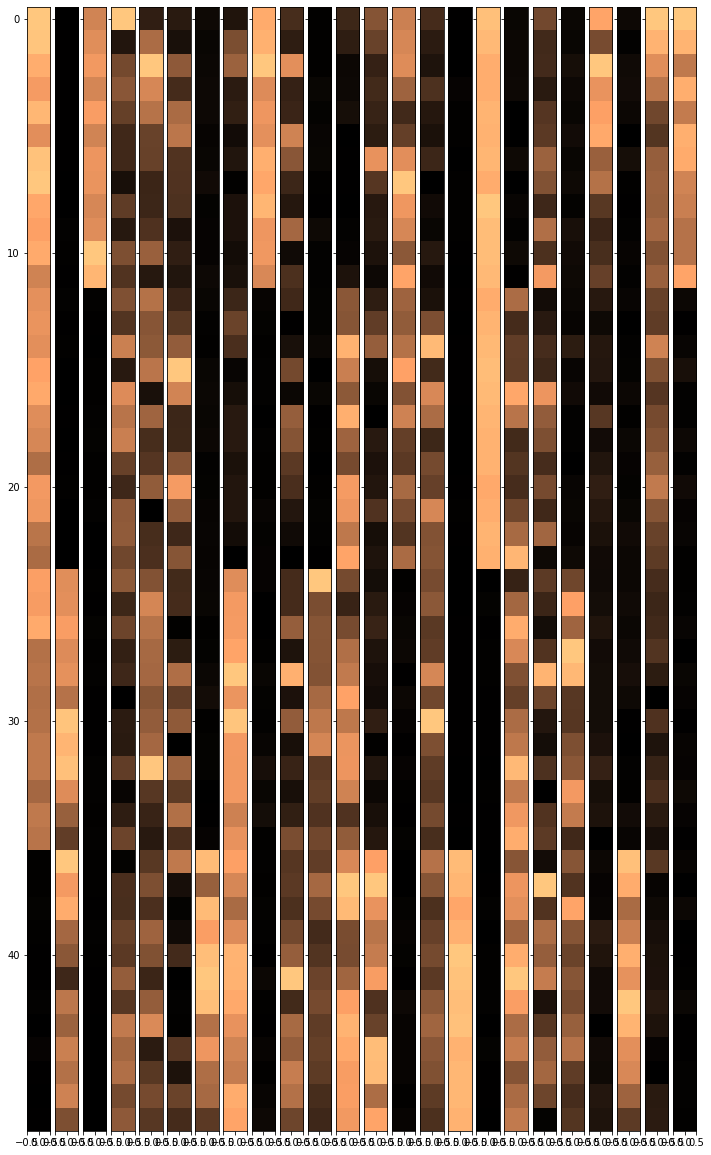

In [150]:
u_norm_rand = u_l_rand.norm(dim=-1,keepdim=True).squeeze(0)

print(u_norm_rand.shape)

show_pc_vals(pc=u_norm_rand , ncol=24, cmap="copper", figsize=(12,50))

### KLD

In [151]:
def test(P,Q):
    P = P.norm(dim=-1) 
    Q = Q.norm(dim=-1)
    #kld =(P * (P / Q).log()).sum()
    #return kld
    print(P.sum(), Q.sum())

In [152]:
idx = 6
print(calc_pc_norm_kld(pc2=u_l[idx], pc1=u_l_tf[idx]))
#print(calc_pc_delta(pc1=u_l[idx], pc2=u_l_tf[idx]))
print(test(Q=u_l[idx], P=u_l_tf[idx]))

tensor(42.5548, grad_fn=<KlDivBackward0>)
tensor(623.6845, grad_fn=<SumBackward0>) tensor(624.0287, grad_fn=<SumBackward0>)
None


#### Multitransform

In [205]:
idx = 9

torch.Size([1, 1, 28, 28])


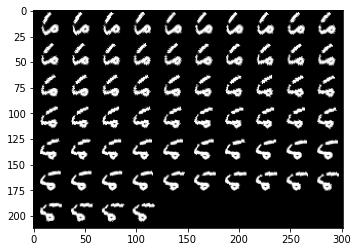

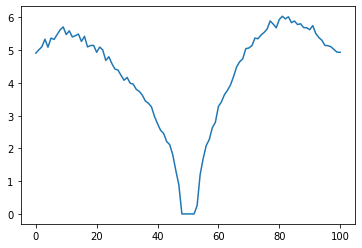

In [206]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_rot(x_aff,y_aff, range=[-50.,50.,1])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)

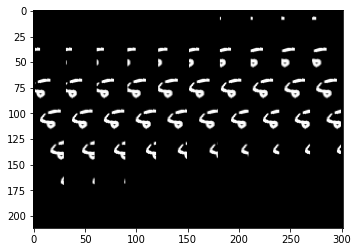

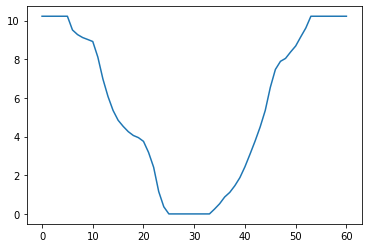

In [207]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_xtrans(img=x_aff, target=y_aff, range=[-30.,30.,1])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)

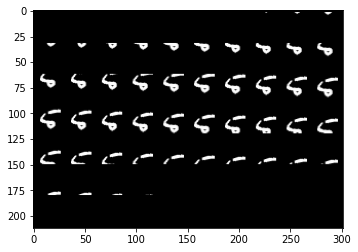

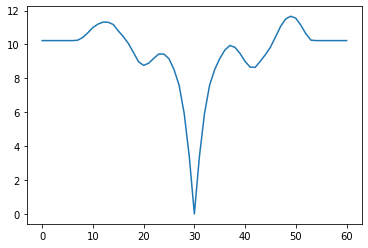

In [208]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_ytrans(img=x_aff, target=y_aff, range=[-30.,30.,1])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)

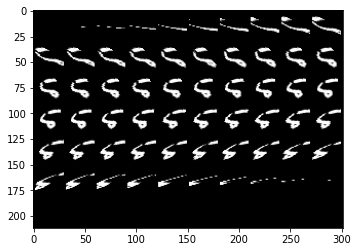

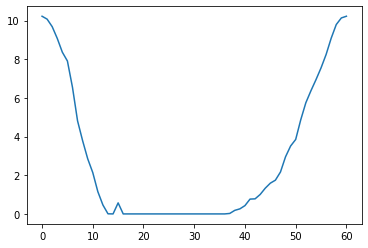

In [209]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_shear(img=x_aff, target=y_aff, range=[-90.,90.,3])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)

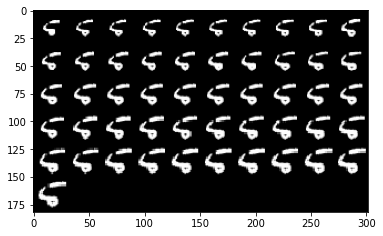

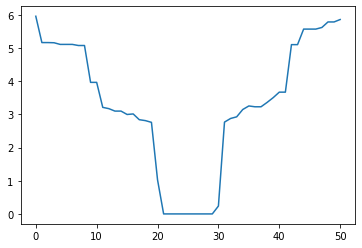

In [210]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_scale(img=x_aff, target=y_aff, range=[0.75,1.25,0.01])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)